# Historical Options Data: EDA and Feature Engineering

## Pipeline Overview
1. **Data Loading**: Load cleaned historical-style options data
2. **Black-Scholes Analysis**: Calculate theoretical prices with robust error handling
3. **Feature Engineering**: Create ML-ready features
4. **Distribution Analysis**: Visualize key variable distributions
5. **Correlation Analysis**: Identify relationships between variables
6. **Outlier Detection**: Flag anomalous observations
7. **Data Export**: Save enhanced dataset for modeling


In [14]:
import sys
sys.path.append('../src')
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from config import Config
from black_scholes import BlackScholesCalculator
from data_processor import OptionsDataProcessor

plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

In [7]:
df = pd.read_csv('../data/processed/cleaned_options_data_20250823_164021.csv')

# Convert datetime columns
datetime_cols = ['expiration_date', 'fetch_timestamp', 'simulated_trade_date']
for col in datetime_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col])

print(f"Contracts by type: {df['contract_type'].value_counts().to_dict()}")

Contracts by type: {'put': 233, 'call': 224}


In [8]:
# Black-Scholes Analysis
bs_calculator = BlackScholesCalculator()
processor = OptionsDataProcessor()

print("Calculating Black-Scholes prices...")
bs_prices = []

for _, row in df.iterrows():
    try:
        # edge cases
        if (row['time_to_expiry'] <= 0 or row['implied_volatility'] <= 0 or 
            row['strike'] <= 0 or row['underlying_price'] <= 0):
            bs_prices.append(np.nan)
            continue
            
        # Price based on option type
        if row['contract_type'] == 'call':
            bs_price = bs_calculator.call_price(
                S=row['underlying_price'],
                K=row['strike'],
                T=row['time_to_expiry'],
                r=row['risk_free_rate'],
                sigma=row['implied_volatility']
            )
        else:  # put
            bs_price = bs_calculator.put_price(
                S=row['underlying_price'],
                K=row['strike'],
                T=row['time_to_expiry'],
                r=row['risk_free_rate'],
                sigma=row['implied_volatility']
            )
        bs_prices.append(bs_price)
    except Exception as e:
        bs_prices.append(np.nan)

df_analysis = processor.calculate_target_variable(df, pd.Series(bs_prices))

df_analysis['abs_pricing_error'] = np.abs(df_analysis['pricing_error'])
df_analysis['relative_error_robust'] = np.where(
    (df_analysis['bs_price'] > 0.01) & (df_analysis['time_to_expiry'] > 0.01),  # Filter criteria
    np.abs(df_analysis['pricing_error'] / df_analysis['bs_price']) * 100,
    np.nan
)

valid_mask = (~df_analysis['pricing_error'].isna()) & (~df_analysis['bs_price'].isna())
valid_df = df_analysis[valid_mask].copy()

print(f"Black-Scholes Analysis (robust):")
print(f"Valid calculations: {valid_mask.sum()}/{len(df_analysis)}")
print(f"Mean absolute pricing error: ${valid_df['abs_pricing_error'].mean():.4f}")
print(f"Median absolute error: ${valid_df['abs_pricing_error'].median():.4f}")
print(f"Mean relative error (filtered): {valid_df['relative_error_robust'].mean():.2f}%")
print(f"Median relative error (filtered): {valid_df['relative_error_robust'].median():.2f}%")

print(f"\nSample results:")
sample_cols = ['strike', 'contract_type', 'market_price', 'bs_price', 'pricing_error', 'abs_pricing_error']
print(valid_df[sample_cols].head().round(6))


Calculating Black-Scholes prices...
Black-Scholes Analysis (robust):
Valid calculations: 457/457
Mean absolute pricing error: $1.7761
Median absolute error: $0.0438
Mean relative error (filtered): 48.49%
Median relative error (filtered): 1.73%

Sample results:
   strike contract_type  market_price    bs_price  pricing_error  \
0   530.0          call       115.380  115.369375       0.010625   
1   550.0          call        95.385   95.371626       0.013374   
2   570.0          call        75.390   75.373887       0.016113   
3   580.0          call        65.395   65.425774      -0.030774   
4   590.0          call        55.395   55.436480      -0.041480   

   abs_pricing_error  
0           0.010625  
1           0.013374  
2           0.016113  
3           0.030774  
4           0.041480  


In [15]:
print("Engineering features...")
enhanced_df = processor.engineer_features(df_analysis)

print("New features created by OptionsDataProcessor:")
# Get only the newly added features
original_cols = set(df_analysis.columns)
new_cols = set(enhanced_df.columns) - original_cols
new_features = list(new_cols)
print(f"Features: {new_features}")

print(f"\nFeature statistics:")
if new_features:
    print(enhanced_df[new_features].describe().round(4))

Engineering features...
New features created by OptionsDataProcessor:
Features: ['is_long_term', 'vol_moneyness', 'log_open_interest', 'log_volume', 'is_itm', 'is_atm', 'sqrt_time_to_expiry', 'vol_time_product', 'days_to_expiry', 'is_short_term', 'is_otm', 'rate_time']

Feature statistics:
       is_long_term  vol_moneyness  log_open_interest  log_volume    is_itm  \
count         457.0       457.0000           457.0000    457.0000  457.0000   
mean            0.0         0.8489             4.9837      3.7103    0.9540   
std             0.0         0.8698             2.2319      2.5612    0.2096   
min             0.0         0.0000             0.6931      0.0000    0.0000   
25%             0.0         0.2255             3.2958      1.3863    1.0000   
50%             0.0         0.5867             5.3181      3.2581    1.0000   
75%             0.0         1.0954             6.7081      5.9162    1.0000   
max             0.0         4.6784            11.2478      9.1336    1.0000  

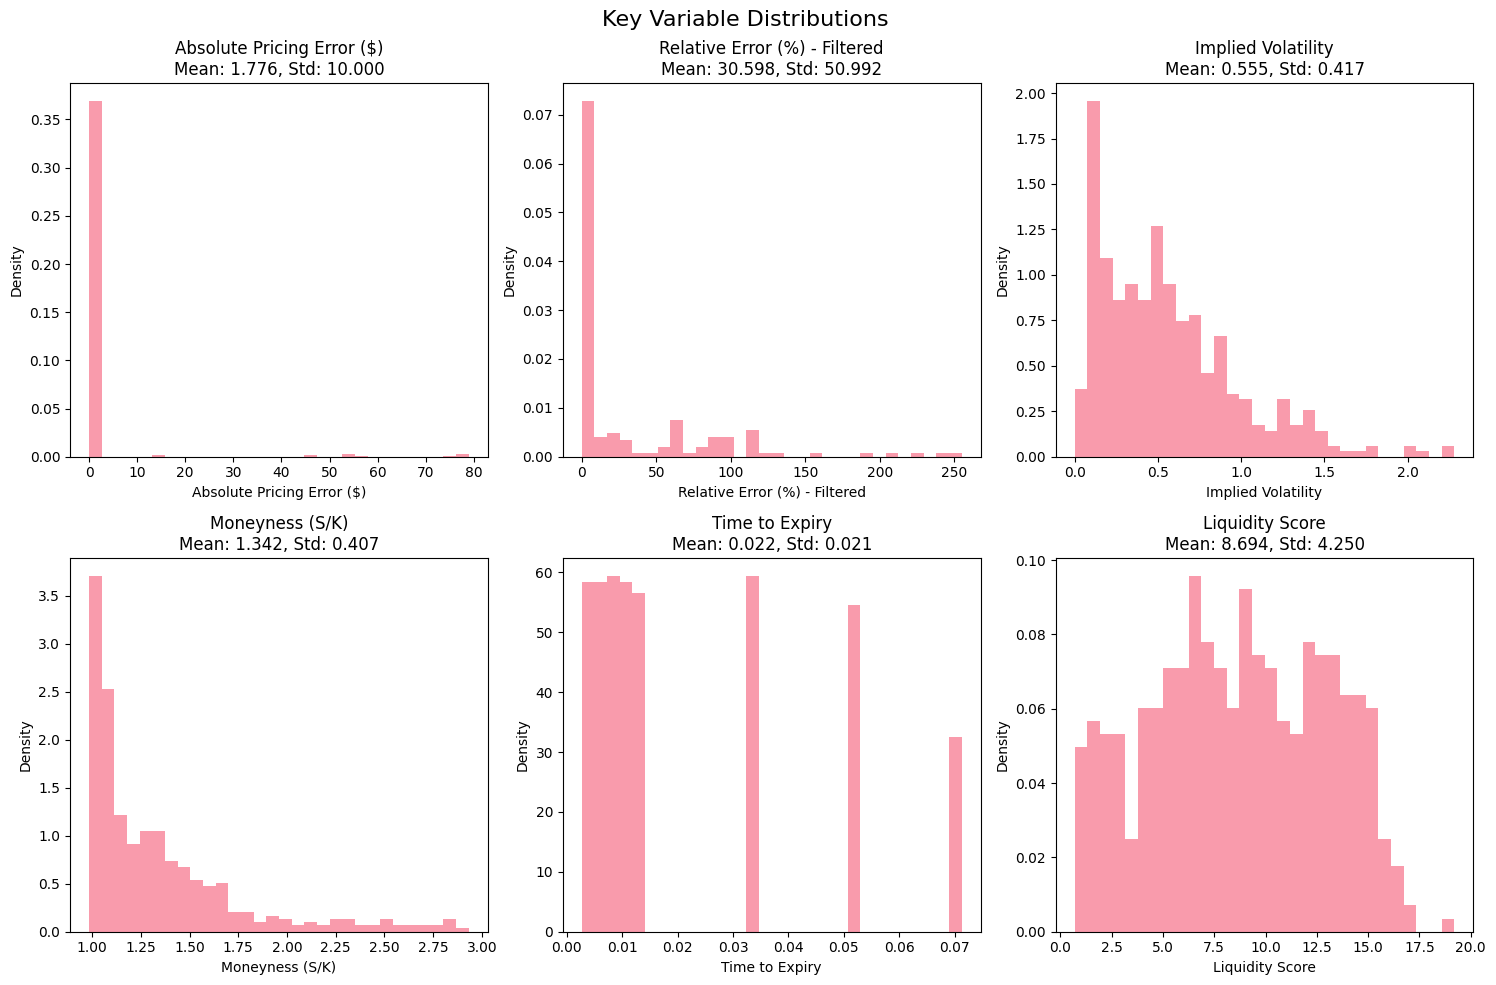

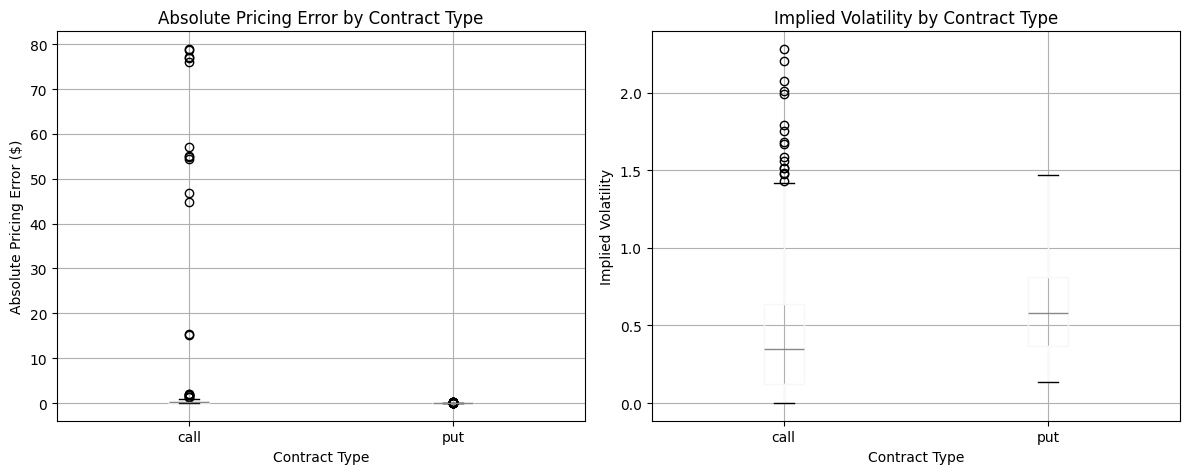

In [10]:
# Distribution Analysis - Visualize key variables
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Key Variable Distributions', fontsize=16)

plot_vars = [
    ('abs_pricing_error', 'Absolute Pricing Error ($)'),
    ('relative_error_robust', 'Relative Error (%) - Filtered'),
    ('implied_volatility', 'Implied Volatility'),
    ('moneyness', 'Moneyness (S/K)'),
    ('time_to_expiry', 'Time to Expiry'),
    ('liquidity_score', 'Liquidity Score')
]

for i, (var, title) in enumerate(plot_vars):
    ax = axes[i//3, i%3]
    
    # Filter out extreme values
    if var == 'relative_error_robust':
        plot_data = df_analysis[var].dropna()
        if len(plot_data) > 0:
            cap_value = plot_data.quantile(0.95)
            plot_data = plot_data[plot_data <= cap_value]
    else:
        plot_data = df_analysis[var].dropna()
    
    if len(plot_data) > 0:
        ax.hist(plot_data, bins=30, alpha=0.7, density=True)
        ax.set_title(f'{title}\nMean: {plot_data.mean():.3f}, Std: {plot_data.std():.3f}')
        ax.set_xlabel(title)
        ax.set_ylabel('Density')
    else:
        ax.text(0.5, 0.5, 'No valid data', transform=ax.transAxes, ha='center')
        ax.set_title(title)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Absolute pricing error by contract type
df_analysis.boxplot(column='abs_pricing_error', by='contract_type', ax=axes[0])
axes[0].set_title('Absolute Pricing Error by Contract Type')
axes[0].set_xlabel('Contract Type')
axes[0].set_ylabel('Absolute Pricing Error ($)')

# Implied volatility by contract type
df_analysis.boxplot(column='implied_volatility', by='contract_type', ax=axes[1])
axes[1].set_title('Implied Volatility by Contract Type')
axes[1].set_xlabel('Contract Type')
axes[1].set_ylabel('Implied Volatility')

plt.suptitle('')
plt.tight_layout()
plt.show()


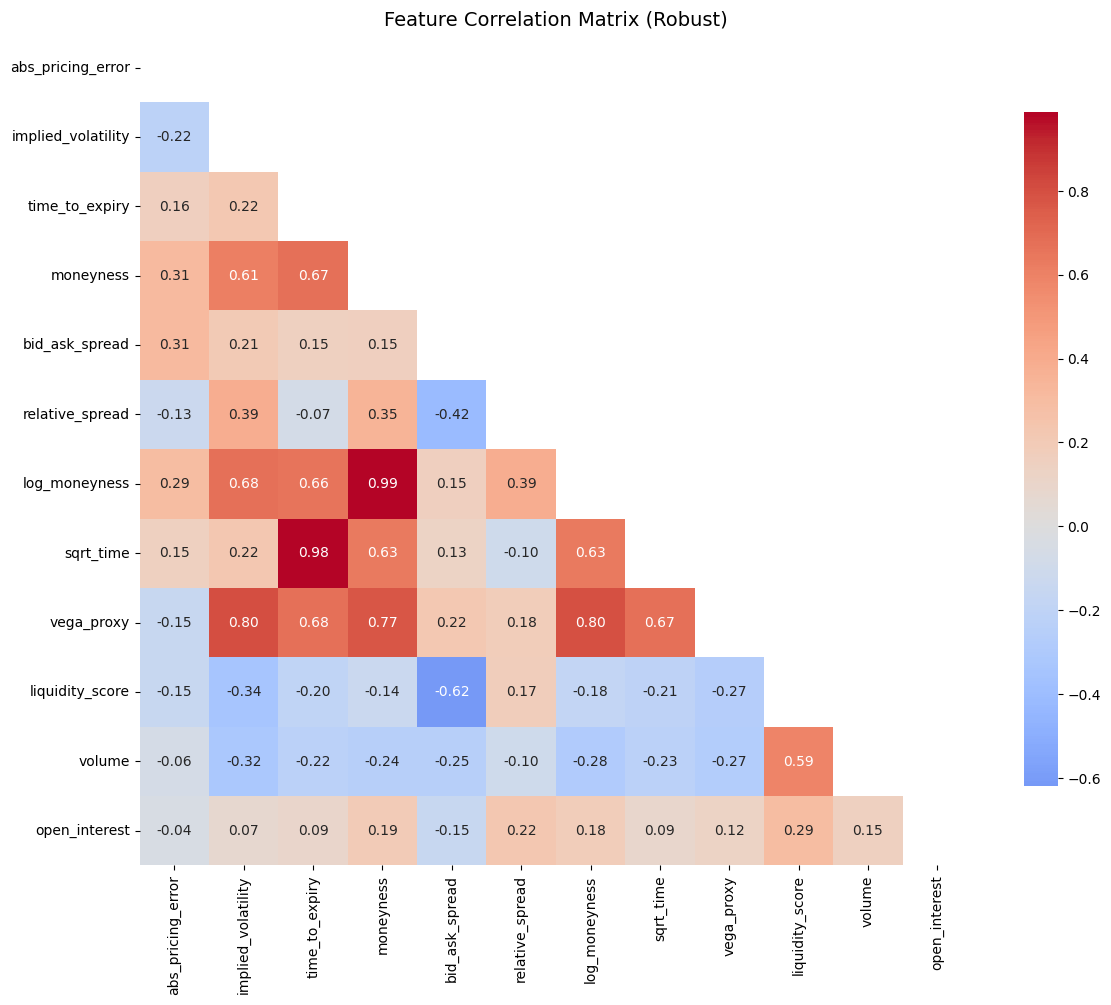

Top correlations with absolute pricing error:
  moneyness: 0.312
  bid_ask_spread: 0.310
  log_moneyness: 0.295
  implied_volatility: 0.216
  time_to_expiry: 0.158
  vega_proxy: 0.154
  sqrt_time: 0.147


In [11]:
# Correlation Analysis
valid_mask_updated = (~df_analysis['pricing_error'].isna()) & (~df_analysis['bs_price'].isna())
valid_df_updated = df_analysis[valid_mask_updated].copy()

analysis_features = [
    'abs_pricing_error', 'implied_volatility', 'time_to_expiry', 'moneyness',
    'bid_ask_spread', 'relative_spread', 'log_moneyness', 'sqrt_time',
    'vega_proxy', 'liquidity_score', 'volume', 'open_interest'
]

# Calculate correlation matrix for valid data with all features
corr_data = valid_df_updated[analysis_features].corr()

# Correlation heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_data, dtype=bool))
sns.heatmap(corr_data, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix (Robust)', fontsize=14)
plt.tight_layout()
plt.show()

# Top correlations with pricing error
print("Top correlations with absolute pricing error:")
pricing_error_corr = corr_data['abs_pricing_error'].abs().sort_values(ascending=False)
for feature, corr in pricing_error_corr.head(8).items():
    if feature != 'abs_pricing_error':
        print(f"  {feature}: {corr:.3f}")


Outlier Detection Analysis
Outlier Detection Results:
Isolation Forest outliers: 46 (10.1%)
Clean data remaining: 411 (89.9%)
Pricing error outliers (IQR): 31 (6.8%)


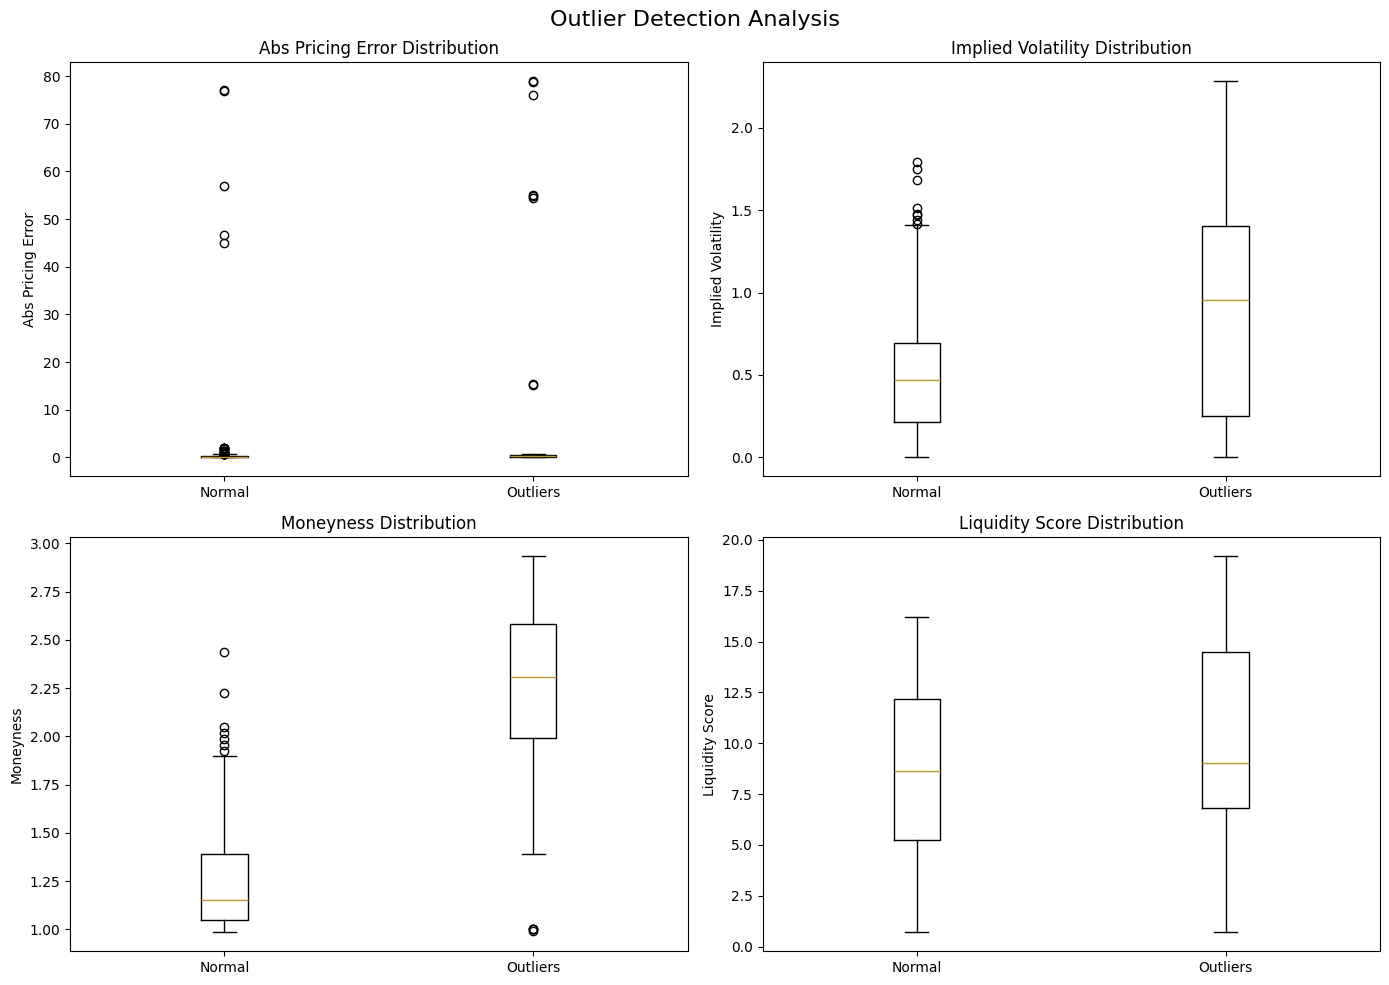


Top 10 absolute pricing error outliers:
  $240 call | Error: $78.938 | Money: 2.689 | TTM: 0.0712
  $255 call | Error: $78.676 | Money: 2.531 | TTM: 0.0712
  $340 call | Error: $77.160 | Money: 1.898 | TTM: 0.0137
  $350 call | Error: $76.946 | Money: 1.844 | TTM: 0.0137
  $390 call | Error: $75.963 | Money: 1.655 | TTM: 0.0137
  $430 call | Error: $56.991 | Money: 1.501 | TTM: 0.0137
  $225 call | Error: $55.009 | Money: 2.868 | TTM: 0.0712
  $235 call | Error: $54.943 | Money: 2.746 | TTM: 0.0712
  $270 call | Error: $54.420 | Money: 2.390 | TTM: 0.0712
  $385 call | Error: $46.726 | Money: 1.676 | TTM: 0.0137


In [16]:
print("Outlier Detection Analysis")

clean_data, outliers = processor.detect_outliers(valid_df_updated, method='isolation_forest')

print(f"Outlier Detection Results:")
print(f"Isolation Forest outliers: {len(outliers)} ({len(outliers)/len(valid_df_updated)*100:.1f}%)")
print(f"Clean data remaining: {len(clean_data)} ({len(clean_data)/len(valid_df_updated)*100:.1f}%)")

# Additional IQR analysis for pricing errors specifically
Q1 = valid_df_updated['abs_pricing_error'].quantile(0.25)
Q3 = valid_df_updated['abs_pricing_error'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
pricing_outliers = (valid_df_updated['abs_pricing_error'] < lower_bound) | (valid_df_updated['abs_pricing_error'] > upper_bound)

print(f"Pricing error outliers (IQR): {pricing_outliers.sum()} ({pricing_outliers.mean()*100:.1f}%)")

# Visualize outliers for key features
outlier_features = ['abs_pricing_error', 'implied_volatility', 'moneyness', 'liquidity_score']
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Outlier Detection Analysis', fontsize=16)

for i, feature in enumerate(outlier_features):
    ax = axes[i//2, i%2]
    
    # Box plot with outliers highlighted
    normal_data = clean_data[feature].dropna() if feature in clean_data.columns else pd.Series()
    outlier_data = outliers[feature].dropna() if feature in outliers.columns else pd.Series()
    
    box_data = []
    box_labels = []
    
    if len(normal_data) > 0:
        box_data.append(normal_data)
        box_labels.append('Normal')
    
    if len(outlier_data) > 0:
        box_data.append(outlier_data)
        box_labels.append('Outliers')
    
    if box_data:
        ax.boxplot(box_data, labels=box_labels)
    else:
        ax.text(0.5, 0.5, 'No data', transform=ax.transAxes, ha='center')
    
    ax.set_title(f'{feature.replace("_", " ").title()} Distribution')
    ax.set_ylabel(feature.replace('_', ' ').title())

plt.tight_layout()
plt.show()

print(f"\nTop 10 absolute pricing error outliers:")
top_outliers = valid_df_updated.nlargest(10, 'abs_pricing_error')[
    ['strike', 'contract_type', 'market_price', 'bs_price', 'abs_pricing_error', 'moneyness', 'time_to_expiry']
]
for _, row in top_outliers.iterrows():
    print(f"  ${row['strike']:.0f} {row['contract_type']} | "
          f"Error: ${row['abs_pricing_error']:.3f} | "
          f"Money: {row['moneyness']:.3f} | TTM: {row['time_to_expiry']:.4f}")

In [17]:
print("ROBUST DATASET SUMMARY\n\n")

print(f"📊 Total observations: {len(enhanced_df):,}")
print(f"📊 Valid BS calculations: {len(valid_df_updated):,} ({len(valid_df_updated)/len(enhanced_df)*100:.1f}%)")
print(f"📊 Contracts by type: {valid_df_updated['contract_type'].value_counts().to_dict()}")

print(f"\n💰 Robust Pricing Analysis:")
print(f"   • Mean absolute error: ${valid_df_updated['abs_pricing_error'].mean():.4f}")
print(f"   • Median absolute error: ${valid_df_updated['abs_pricing_error'].median():.4f}")
print(f"   • 95th percentile error: ${valid_df_updated['abs_pricing_error'].quantile(0.95):.4f}")
print(f"   • Mean relative error (filtered): {valid_df_updated['relative_error_robust'].mean():.2f}%")

print(f"\n📈 Market Structure:")
print(f"   • ATM contracts: {valid_df_updated['atm'].sum()} ({valid_df_updated['atm'].mean()*100:.1f}%)")
print(f"   • ITM contracts: {valid_df_updated['itm'].sum()} ({valid_df_updated['itm'].mean()*100:.1f}%)")
print(f"   • OTM contracts: {valid_df_updated['otm'].sum()} ({valid_df_updated['otm'].mean()*100:.1f}%)")

print(f"\n⏰ Time Distribution:")
print(f"   • Mean time to expiry: {valid_df_updated['time_to_expiry'].mean():.4f} years")
print(f"   • Short-term (<2 weeks): {(valid_df_updated['time_to_expiry'] < 0.04).sum()} contracts")

timestamp = pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')
output_file = f'../data/processed/eda_features_{timestamp}.csv'
enhanced_df.to_csv(output_file, index=False)
print(f"\n💾 Enhanced dataset saved: {output_file}")

all_features = list(enhanced_df.columns)
print(f"\n🎯 Total features available: {len(all_features)}")
print("Available for modeling:", [f for f in all_features if f not in ['symbol', 'fetch_timestamp', 'simulated_trade_date']])

ROBUST DATASET SUMMARY


📊 Total observations: 457
📊 Valid BS calculations: 457 (100.0%)
📊 Contracts by type: {'put': 233, 'call': 224}

💰 Robust Pricing Analysis:
   • Mean absolute error: $1.7761
   • Median absolute error: $0.0438
   • 95th percentile error: $0.8414
   • Mean relative error (filtered): 48.49%

📈 Market Structure:
   • ATM contracts: 56 (12.3%)
   • ITM contracts: 168 (36.8%)
   • OTM contracts: 233 (51.0%)

⏰ Time Distribution:
   • Mean time to expiry: 0.0217 years
   • Short-term (<2 weeks): 366 contracts

💾 Enhanced dataset saved: ../data/processed/eda_features_20250828_124328.csv

🎯 Total features available: 47
Available for modeling: ['underlying_symbol', 'strike', 'expiration_date', 'contract_type', 'implied_volatility', 'open_interest', 'volume', 'bid', 'ask', 'last_price', 'market_price', 'underlying_price', 'risk_free_rate', 'time_to_expiry', 'data_source', 'moneyness', 'bs_price', 'pricing_error', 'relative_error', 'abs_pricing_error', 'relative_error_robu